# Lista de Exercícios 3: Aproximação de Funções

#### Disciplina: Aprendizado por Reforço
#### Professor: Luiz Chaimowicz
#### Monitores: Marcelo Lemos e Ronaldo Vieira

---

## Instruções

- Leia atentamente toda a lista de exercícios e familiarize-se com o código fornecido **antes** de começar a implementação.
- Os locais onde você deverá escrever suas soluções estão demarcados com comentários `# YOUR CODE HERE` ou `YOUR ANSWER HERE`.
- **Não altere o código fora das áreas indicadas, nem adicione ou remova células. O nome deste arquivo também não deve ser modificado.**
- Antes de submeter, certifique-se de que o código esteja funcionando do início ao fim sem erros.
- Submeta apenas este notebook (*ps3.ipynb*) com as suas soluções no Moodle.
- Prazo de entrega: 05/06/2025. **Submissões fora do prazo terão uma penalização de -20% da nota final por dia de atraso.**
- ***SUBMISSÕES QUE NÃO SEGUIREM ESTAS INSTRUÇÕES NÃO SERÃO AVALIADAS.***
- Utilize a [documentação do Gymnasium](https://gymnasium.farama.org/) para auxiliar sua implementação.
- Em caso de dúvidas entre em contato pelo fórum "Dúvidas com relação aos exercícios e trabalho de curso" no moodle da Disciplina.

---

## Mountain Car

Mountain Car é um ambiente no qual um agente precisa conduzir um carro até o topo de uma montanha. No entanto, o motor do carro não é potente o suficiente para subir diretamente até o topo. Por isso, o agente precisa aprender a aproveitar o impulso - movendo-se para frente e para trás - para ganhar velocidade suficiente e alcançar o topo.

![](https://gymnasium.farama.org/_images/mountain_car.gif)

O espaço de observação é contínuo e composto por dois valores: a posição e a velocidade do carro. O agente pode escolher entre três ações discretas: acelerar o carro para a esquerda, acelerar para a direita, ou não acelerar. A posição inicial do agente é definida de forma uniformemente aleatória no intervalo $[-0.6, -0.4]$. O episódio se encerra quando o carro atinge o topo da montanha à direita (posição $0.5$) ou quando o limite de 200 passos é atingido. A cada passo, o agente recebe uma penalidade de $-1$, incentivando-o a alcançar o objetivo no menor número possível de passos. Para mais detalhes sobre o ambiente leia a [documentação do gymnasium](https://gymnasium.farama.org/environments/classic_control/mountain_car/).

Devido à natureza contínua do espaço de estados, métodos tabulares não são eficazes. Assim, é comum o uso de técnicas de aproximação de função para solucionar o problema de forma eficiente. Nesta lista de exercícios, você irá trabalhar com o ambiente Mountain Car descrito acima. Seu objetivo será implementar o algoritmo *Semi-Gradient Episodic Sarsa* com aproximação linear e explorar como diferentes técnicas de construção de features influenciam o desempenho do agente.

## Semi-Gradient Episodic Sarsa

Nesta atividade, você implementará um agente baseado no algoritmo Semi-Gradient Episodic SARSA, utilizando uma **função de valor linear**.

Antes de iniciar sua implementação, analise a interface `FeatureExtractor` fornecida abaixo. Ela será a base para os construtores de features que você implementará na próxima seção. O agente utilizará um objeto com essa interface para extrair features a partir das observações dos estados.

In [1]:
from abc import ABC, abstractmethod

import numpy as np
import gymnasium as gym
import sklearn
import matplotlib.pyplot as plt

In [2]:
class FeatureExtractor(ABC):
    """
    Interface for feature extractors that convert environment states into feature vectors.
    """

    @property
    @abstractmethod
    def feature_size(self):
        """
        Property that returns the size of the feature vector produced by this extractor.

        Returns:
            An integer representing the length of the feature vector.
        """
        pass

    @abstractmethod
    def extract(self, state):
        """
        Converts a raw state into a 1D feature vector.

        Args:
            state: The observation state from the environment.

        Returns:
            The extracted feature vector representation.
        """
        pass

Siga as instruções abaixo para implementar seu agente:

1. Implemente o método `__init__` que inicializa um novo agente. Ele deve receber como parâmetros o espaço de observações, o espaço de ações, um construtor de features (`feature_extractor`), a taxa de aprendizado $\alpha$, o fator de desconto $\gamma$, e o parâmetro de exploração $\varepsilon$. Inicialize os pesos do modelo na variável `self.weights`.
2. Implemente o método `compute_q_values`, que recebe um vetor de features e calcula os *Q-values* de acordo com a entrada.
3. Implemente o método `choose_action`, responsável por escolher uma ação a partir de um estado observado, seguindo a política $\varepsilon$-greedy.
4. Implemente o método `learn`, que atualiza os pesos do agente com base na experiência obtida durante a interação com o ambiente.
5. Implemente o método `train`, que executa o loop de treinamento do algoritmo Sarsa. O ambiente de treinamento e o número de episódios devem ser fornecidos como parâmetros de entrada. O método deve retornar uma lista com a soma das recompensas obtidas ao longo de cada episódio.

In [3]:
class SGESAgent:
    def __init__(
        self,
        observation_space,
        action_space,
        feature_extractor,
        alpha=0.01,
        gamma=0.99,
        epsilon=0.1,
    ):
        # YOUR CODE HERE
        self.observation_space = observation_space
        self.action_space = action_space
        self.feature_extractor = feature_extractor

        self.e = epsilon
        self.g = gamma
        self.a = alpha

        self.w = np.zeros((action_space.n, feature_extractor.feature_size))

    def compute_q_values(self, features):
        # YOUR CODE HERE
        return np.dot(self.w, features)

    def choose_action(self, state):
        # YOUR CODE HERE
        if np.random.random() < self.e:
            return self.action_space.sample()

        features = self.feature_extractor.extract(state)
        q_values = self.compute_q_values(features)
        return np.argmax(q_values)

    def learn(self, state, action, reward, next_state, next_action, done):
        # YOUR CODE HERE
        features = self.feature_extractor.extract(state)

        if done:
            q_target = reward
        else:
            q_target = reward + self.g * np.dot(
                self.w[next_action], self.feature_extractor.extract(next_state)
            )

        td_error = q_target - np.dot(self.w[action], features)

        self.w[action] += self.a * td_error * features

    def train(self, env, episodes=500):
        # YOUR CODE HERE
        rewards = []

        for e in range(episodes):
            state, _ = env.reset()
            action = self.choose_action(state)
            episode_return = 0
            done = False

            while not done:
                next_state, reward, term, trunc, _ = env.step(action)
                done = term or trunc
                episode_return += reward

                if not done:
                    next_action = self.choose_action(next_state)

                    self.learn(state, action, reward, next_state, next_action, done)

                    state = next_state
                    action = next_action

                else:
                    self.learn(state, action, reward, next_state, None, done)

            rewards.append(episode_return)

        return rewards


In [4]:
# Não altere ou remova esta célula

In [5]:
# Não altere ou remova esta célula

In [6]:
# Não altere ou remova esta célula

In [7]:
# Não altere ou remova esta célula

In [8]:
# Não altere ou remova esta célula

## Construção de Features

Com o algoritmo do agente pronto, você deverá implementar 3 modelos de construtores de features diferentes:

1. **Modelo Identidade**
2. **Modelo Tile Coding**
3. **Modelo de Funções de Base Radial**

### Identidade

6. Implemente o `IdentityFeatureExtractor`, cujo método `extract` apenas retorna a observação de entrada, sem realizar nenhuma operação nela.

In [9]:
class IdentityFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space):
        # YOUR CODE HERE
        (self._feature_size,) = observation_space.shape

    @property
    def feature_size(self):
        # YOUR CODE HERE
        return self._feature_size

    def extract(self, state):
        # YOUR CODE HERE
        return np.array(state)

In [10]:
# Não altere ou remova esta célula

7. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `IdentityFeatureExtractor`. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.1$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene os retornos episódicos, obtidos no método `train`, na variável `identity_agent`.

In [11]:
env = gym.make("MountainCar-v0")

# YOUR CODE HERE
identity_semi_gradient_episodic_sarsa_agent = SGESAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    feature_extractor=IdentityFeatureExtractor(env.observation_space),
    alpha=0.01,
    gamma=0.99,
    epsilon=0.1,
)

identity_agent = identity_semi_gradient_episodic_sarsa_agent.train(env, episodes=500)

env.close()

In [12]:
# Não altere ou remova esta célula

### Tile Coding

8. Implemente o `TileCodingFeatureExtractor`, cujo método `extract` gera um vetor de features utilizando a técnica de *tile coding*. A quantidade de tilings a ser gerada é definida pelo parâmetro `num_tilings`, enquanto a quantidade de divisões por dimensão em cada tiling é definida pelo parâmetro `tiles_per_dim`. Ambos valores são fornecidos ao construtor da classe. Por exemplo: um `TileCodingFeatureExtractor` com `num_tilings = 3` e `tiles_per_dim = 2` deve gerar 3 tilings, cada um dividindo o espaço em uma grade de tamanho 2$\times$2.

**Importante:** Após a implementação, realize experimentos variando os valores de `num_tilings` e `tiles_per_dim` para identificar as configurações que resultam em melhor desempenho de aprendizado.

In [13]:
class TileCodingFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space, num_tilings, tiles_per_dim):
        # YOUR CODE HERE
        self.observation_space = observation_space
        self.num_tilings = num_tilings
        self.tiles_per_dim = tiles_per_dim

        self.low = observation_space.low
        self.high = observation_space.high
        self.dims = len(self.low)

        self.tiles_per_tiling = tiles_per_dim**self.dims
        self._feature_size = self.num_tilings * self.tiles_per_tiling

        self.offsets = np.array(
            [
                [
                    (i / num_tilings) * (self.high[dim] - self.low[dim]) / tiles_per_dim
                    for dim in range(self.dims)
                ]
                for i in range(num_tilings)
            ]
        )

    @property
    def feature_size(self):
        # YOUR CODE HERE
        return self._feature_size

    def extract(self, state):
        # YOUR CODE HERE
        state = np.array(state)
        features = np.zeros(self._feature_size)

        for tiling_idx in range(self.num_tilings):
            offset_state = state + self.offsets[tiling_idx]

            tile_indices = [
                np.clip(
                    int(
                        (offset_state[dim] - self.low[dim])
                        / (self.high[dim] - self.low[dim])
                        * self.tiles_per_dim
                    ),
                    0,
                    self.tiles_per_dim - 1,
                )
                for dim in range(self.dims)
            ]

            single_tile_idx = 0
            multiplier = 1
            for dim in range(self.dims):
                single_tile_idx += tile_indices[dim] * multiplier
                multiplier *= self.tiles_per_dim

            feature_idx = tiling_idx * self.tiles_per_tiling + single_tile_idx
            features[feature_idx] = 1.0

        return features

In [14]:
# Não altere ou remova esta célula

9. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `TileCodingFeatureExtractor` com `num_tilings = 6` e `tiles_per_dim = 6`. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.1$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene os retornos episódicos, obtidos no método `train`, na variável `tile_agent`.

In [15]:
env = gym.make("MountainCar-v0")

# YOUR CODE HERE
tile_coding_semi_gradient_episodic_sarsa_agent = SGESAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    feature_extractor=TileCodingFeatureExtractor(
        observation_space=env.observation_space, num_tilings=6, tiles_per_dim=6
    ),
    alpha=0.01,
    gamma=0.99,
    epsilon=0.1,
)

tile_agent = tile_coding_semi_gradient_episodic_sarsa_agent.train(env, episodes=500)

env.close()

In [16]:
# Não altere ou remova esta célula

### Funções de Base Radial

10. Implemente o `RBFFeatureExtractor`, cujo método `extract` gera um conjunto de features baseadas em *Radial Basis Functions*. A quantidade total de componentes a ser gerada é definida pelo parâmetro `n_components`, fornecido ao construtor da classe. Utilize a biblioteca *scikit-learn* (sklearn) para auxiliar sua implementação.

**Importante:** Você pode combinar RBFs com diferentes parâmetros para capturar melhor dinâmicas complexas do ambiente e potencialmente melhorar o desempenho do agente. Após a implementação, realize experimentos variando essas configurações para identificar as combinações que produzem os melhores resultados de aprendizado. Normalizar o vetor de entrada também pode facilitar o aprendizado.

In [17]:
class RBFFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space, n_components):
        # YOUR CODE HERE
        self.observation_space = observation_space
        self.n_components = n_components

        self.low = observation_space.low
        self.high = observation_space.high
        (self._feature_size,) = observation_space.shape

        self.scaler = sklearn.preprocessing.StandardScaler()
        self._nsamples = 10000
        sample_states = np.random.uniform(
            low=self.low, high=self.high, size=(self._nsamples, self._feature_size)
        )
        self.scaler.fit(sample_states)

        self.rbf_sampler = sklearn.kernel_approximation.RBFSampler(
            n_components=n_components, gamma=1.0, random_state=42
        )
        normalized_samples = self.scaler.transform(sample_states)
        self.rbf_sampler.fit(normalized_samples)

    @property
    def feature_size(self):
        # YOUR CODE HERE
        return self.n_components

    def extract(self, state):
        # YOUR CODE HERE
        state = np.array(state).reshape(1, -1)

        normalized_state = self.scaler.transform(state)

        rbf_features = self.rbf_sampler.transform(normalized_state)

        return rbf_features.flatten()

In [18]:
# Não altere ou remova esta célula

11. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `RBFFeatureExtractor` com 100 componentes. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.1$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene os retornos episódicos, obtidos no método `train`, na variável `rbf_agent`.

In [19]:
env = gym.make("MountainCar-v0")

# YOUR CODE HERE
rbf_semi_gradient_episodic_sarsa_agent = SGESAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    feature_extractor=RBFFeatureExtractor(
        observation_space=env.observation_space, n_components=100
    ),
    alpha=0.01,
    gamma=0.99,
    epsilon=0.1,
)

rbf_agent = rbf_semi_gradient_episodic_sarsa_agent.train(env, episodes=500)

env.close()

In [20]:
# Não altere ou remova esta célula

## Análise

12. Utilize a biblioteca matplotlib para construir um gráfico comparativo dos retornos episódicos obtidos pelos agentes utilizando cada um dos construtores de features implementados. Utilize as variáveis `null_agent`, `poly_agent` e `rbf_agent` obtidas nos exercícios anteriores. No eixo X, represente os episódios; no eixo Y, o retorno acumulado por episódio. Caso seja necessário, aplique uma média movel para suavizar as curvas e deixar as tendências mais evidentes. Inclua título, legendas e rótulos de eixos apropriados para facilitar a interpretação. Se utilizar algum tipo de suavização, indique claramente no gráfico qual o método aplicado.

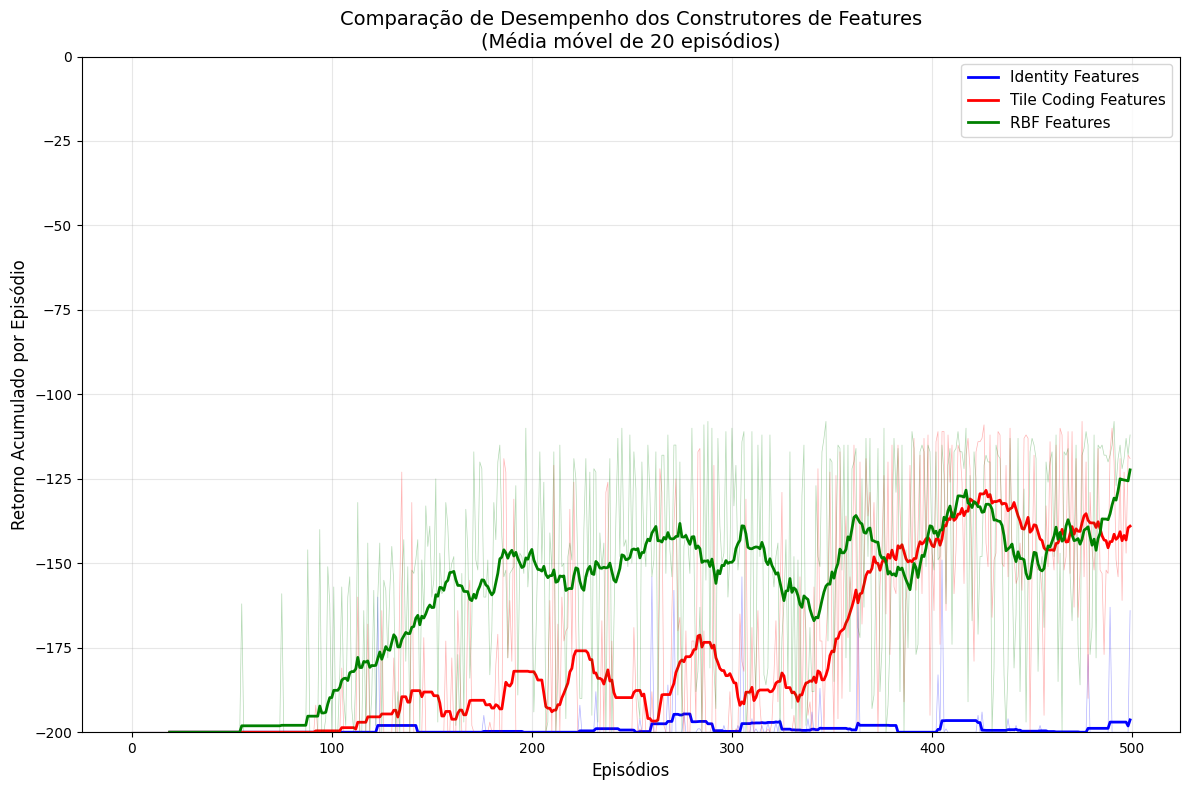

Resumo do Desempenho (últimos 50 episódios):
--------------------------------------------------
Identity Features - Média: -198.0
Tile Coding Features - Média: -140.3
RBF Features - Média: -133.1


In [26]:
# YOUR CODE HERE
class FeatureChart:
    def __init__(self, agent):
        self._agent = agent

    @property
    def episodes(self):
        return range(len(self._agent))
    
    @property
    def smoothed(self, window_size=20):
        return np.convolve(self._agent, np.ones(window_size) / window_size, mode="valid")
    
    @property
    def smoothed_episodes(self, window_size=20):
        return range(window_size - 1, len(self._agent))

plt.figure(figsize=(12, 8))

# identity
identity_chart = FeatureChart(identity_agent)
plt.plot(identity_chart.episodes, identity_chart._agent, alpha=0.3, color="blue", linewidth=0.5)
plt.plot(
    identity_chart.smoothed_episodes, identity_chart.smoothed, color="blue", linewidth=2, label="Identity Features"
)

# tile
tile_chart = FeatureChart(tile_agent)
plt.plot(tile_chart.episodes, tile_chart._agent, alpha=0.3, color="red", linewidth=0.5)
plt.plot(
    tile_chart.smoothed_episodes, tile_chart.smoothed, color="red", linewidth=2, label="Tile Coding Features"
)

# rbf
rbf_chart = FeatureChart(rbf_agent)
plt.plot(rbf_chart.episodes, rbf_chart._agent, alpha=0.3, color="green", linewidth=0.5)
plt.plot(
    rbf_chart.smoothed_episodes, rbf_chart.smoothed, color="green", linewidth=2, label="RBF Features"
)


plt.xlabel("Episódios", fontsize=12)
plt.ylabel("Retorno Acumulado por Episódio", fontsize=12)
plt.title(
    f"Comparação de Desempenho dos Construtores de Features\n(Média móvel de {20} episódios)",
    fontsize=14,
)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(-200, 0)
plt.tight_layout()
plt.show()


# ================ apenas 

print("Resumo do Desempenho (últimos 50 episódios):")
print("-" * 50)
print(f"Identity Features - Média: {np.mean(identity_agent[-50:]):.1f}")
print(f"Tile Coding Features - Média: {np.mean(tile_agent[-50:]):.1f}")
print(f"RBF Features - Média: {np.mean(rbf_agent[-50:]):.1f}")


13. Explique por que a modelagem do construtor de features pode ser crucial para o desempenho de um agente que utiliza aproximação de função.

Em problemas que utilizam o método de otimização de função, a forma com que as features são construídas impacta no aprendizado do agente. Em problemas com estados contínuos, como o Mountain Car, não é viável a utilização de algoritmos tabulares (como Q-learning), uma vez que a exploração de todo o espaço de estados pode ser inviável em tempo hábil, tornando-se necessária a transformação dos dados de para uma forma que permita ao agente entender e aprender com eles. Portanto, a definição de features é o que maior impacta no aprendizado do agente, e o construtor é o responsável por determiná-las, ou seja, de certa forma é o responsável por determinar como o modelo interpreta o ambiente. Uma modelagem ruim pode impactar no treinamento do modelo, por exemplo diminuindo a sua capacidade de generalização. Além disso, há um problema de dimensionalidade. A existencia de um conjunto muito grande de features (ou de features *ruins*) pode impactar no treinamento, por exemplo tornando-o mais computacionalmente custoso. Contudo, é necessário encontrar um balanço no tamanho desse conjunto, ou seja, no número de features (e em sua qualidade), uma vez que, caso esse número seja muito pequeno, também há um impacto negativo no aprendizado. Portanto, as features são fundamentais em diversos aspectos do aprendizado. No caso de problemas modelados a partir da aproximação de função, elas são cruciais no resultado do treinamento, ajudando a evitar que o modelo aprenda apenas ruído (overfitting) ou que ele basicamente não aprenda (underfitting). Por esse motivo, a modelagem do construtor de features é bastante crítica para o sucesso do aprendizado.


14. Quais critérios devem guiar a escolha dos modelos e da quantidade de features a serem utilizadas na construção do espaço de features?

A escolha do modelo e das features varia de acordo com o tipo de problema a ser resolvido. Ou seja, deve sempre ser considerada a complexidade do problema e do ambiente a ser modelado. Caso o ambiente seja mais complexo - por exemplo, com um maior espaço de ações - e contínuo, faz-se fundamental a existência de um conjunto de features mais elaboradas, modeladas a partir de construtores mais sofisticados, como o RBF ou baseados em redes neurais. Entretanto, é preciso ter cautela com o overfitting, ou seja, com os casos que o modelo *decora* o conjunto de treinamento e não possui nenhuma capacidade de generalização. Em alguns casos, pode ser mais interessante optar por modelos mais simples, como o Tile Coding, ou Identity. É fundamental encontar um estado intermediário, ou seja, utilizar-se de um bom conjunto de features (qualidade acima de quantidade). Além disso, dependendo do domínio, é possível aproveitar de padrões do próprio problema, encontrados a partir da visualização e da interpretação detalhada do contexto a ser modelado, como simetrias ou ciclos. Entretanto, é fundamental o exercício de testes de hiperparâmetros, comparação de resultados e reajuste até encontrar uma boa combinação de resultados que garanta estabilidade, *velocidade* e capacidade de generalização.